# Etude de la détection automatique de caractéristiques sur un signal audio
![ISEN Lille](src/isen.jpg)



Référents :
* A. Frappé 
* A. Gonzalez
* B. Larras

Projet M1 réalisé par :
* J. Le Bellego
* S. Lecoq

# Mise en place

Ce notebook [Jupyter](http://jupyter.org/) se compose de deux types de cellules :

- Celles contenant du **code Python** peuvent être exécuté en appuyant sur simultanément sur les touches *Maj + Entrée*.  
- Celles contenant du **rendu** ou du **markdown** n'ont aucun effet particulier en dehors de contenir du texte.

Le code est prévu pour être exécuté au moins une fois dans l'ordre afin de pouvoir définir tous les éléments, après quoi il vous est possible d'éditer et d'exécutez une celulle en particulier.

**Nota Bene** : Il est possible de masquer certaines portions de code pour rendre le document plus lisible, en cliquant sur l'un des deux boutons ci-dessous.

### Initialisation et dépendances 
Etape intermédiaire consistant à importer les bibliothèques.

In [1]:
%%html
<script>
//!masquer
IPython.OutputArea.prototype._should_scroll = lines => { return false }
function show_code() { $('div.input').show() }   
function hide_code() { $("div.input").each((i, input) => /!masquer/i.test($(input).text()) ? $(input).hide() : $(input).show()) }                 
</script>
<form action="javascript:show_code()" style="float:left"><input type="submit" style="width:200px;padding:4px;border-radius:5px;margin:10px" value="Forcer l'affichage du code"></form>
<form action="javascript:hide_code()" style="float:left"><input type="submit" style="width:200px;padding:4px;border-radius:5px;margin:10px" value="Masquer les codes"></form>


In [2]:
#!masquer
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.io.wavfile as sw
import math
from scipy import signal
from scipy.signal import butter, lfilter
from operator import add
np.seterr(divide='ignore');

# Fichier audio

La source du fichier audio qui sera utilisée par le reste du programme peut être configurée dans la cellule ci-dessous.

In [3]:
# Source
file = "src/test2.wav"

Ci-dessous sont définit automatiquement les paramètres du fichier source :
* **y** : Signal d'entrée
* **fs** : Fréquence d'échantillonage de ce signal
* **N** : Nombre de points échantillonés
* **t** : Points temporels

In [4]:
# Lecture du fichier audio
fs, y = sw.read(file)
# Nombre d'échantillons et échelle temporelle
N = len(y)
t = np.linspace(0, N/fs, N)

### Spectre d'amplitude

Il représente l'amplitude relative des impulsions sonores (en ordonnée) selon le temps (en abscisse).

Il est affiché par la fonction **plot_specamp(y, t)**.

In [5]:
#! masquer
# Affiche le spectre d'amplitude
# > y : Liste d'amplitudes
# > t : Echelle temporelle
def plot_specamp(y, t):
    plt.figure(figsize=(16, 4), dpi= 80, facecolor="w", edgecolor="k")
    plt.title("Piste audio")
    plt.xlabel("Temps [s]")
    plt.ylabel("Amplitude [Ø]")
    plt.xlim(0, t[-1])
    plt.ylim(-1, +1)
    plt.plot(t, y)
    plt.show()

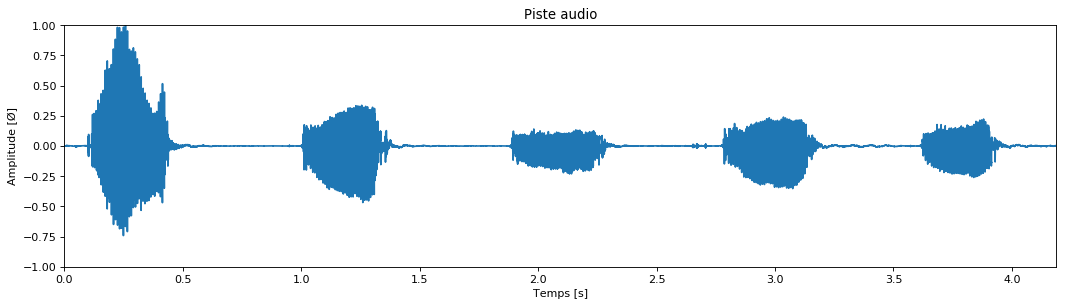

In [6]:
plot_specamp(y/max(abs(y)), t)

### Spectrogramme

Il représente la densité spectrale de puissance (par nuances de couleurs) par fréquence (en ordonnée) selon le temps (en abscisse). Les couleurs chaudes indiquent une forte énergie tandis que les couleurs froides en montrent l'absence.

Il est affiché par la fonction **plot_specgram(y, t, fs)**.

In [7]:
#!masquer
# Affiche le spectrogramme
# > y : Liste d'amplitudes
# > t : Echelle temporelle
# > fs : Fréquence d'échantillonage
def plot_specgram(y, t, fs):
    plt.figure(figsize=(16, 4), dpi= 80, facecolor="w", edgecolor="k")
    plt.title("Spectrogramme")
    plt.ylabel("Frequency [Hz]")
    plt.xlabel("Time [s]")
    plt.specgram(y, Fs=fs)
    plt.ylim(0, 20000)
    plt.xlim(0, t[-1])
    plt.show()

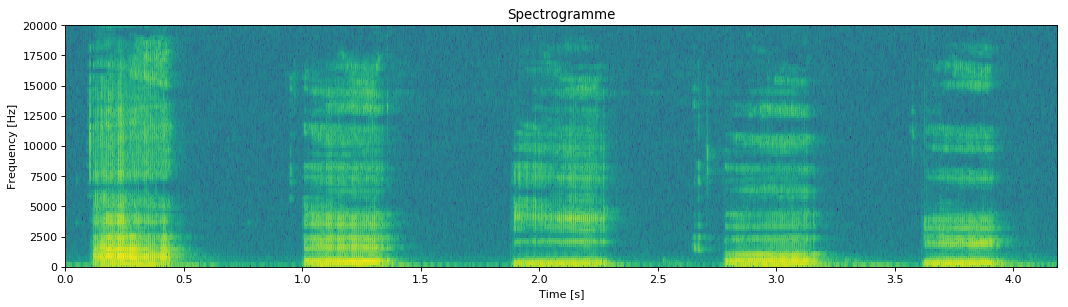

In [8]:
plot_specgram(y, t, fs)

# Banque de filtres

Ci-dessous se trouvent les paramètres de la banque de filtres :
* **fmin** : Fréquence centrale minimum
* **fmax** : Fréquence centrale maximum
* **nb_filters** : Nombre de filtres
* **n** : Ordre des filtres
* **q** : Facteur qualité

Ainsi que les paramètres de génération des spectrogrammes :
* **time_res** : Résolution temporelle (∈ [0, 1[), influe sur le *noverlap*
* **amp_res** : Résolution d'amplitude (indiquer le nombre de bits pour stocker l'amplitude)

In [9]:
# Fréquence minimal
fmin = 300
# Fréquence maximal
fmax = 3000
# Nombre de filtres
nb_filters = 12

# Ordre des filtres
n = 3
# Facteur de qualité
q = 3

# Résolution temporelle des spectrogramme (entre 0 et 1 exclu, sinon le pc va mourir))
time_res = 0.5
# Nombre de bits à utiliser pour pour stocker l'amplitude d'energie
amp_res = 4

### Génération de la banque de filtres
Etape intermédiaire qui consiste à générer les différents filtres de la banque en fonction des paramètres ci-dessus.

La banque est générée à l'aide de la fonction **gen_filters(fmin, fmax, nb_filters, q, n, fs, debug=False)** qui effectue plusieurs appels à la fonction **bandpass(fc, q, n, fs, debug=False)**.

In [10]:
#!masquer
# Génère un filtre passe-bande
# > fc : Fréquence centrale
# > q : Facteur de qualité
# > n : Ordre du filtre
# > fs : Fréquence d'échantillonage
# > [debug] : Si actif, affiche les informations sur le filtre généré
# < filter : Filtre de Butterworth avec les caractéristiques indiquées
# < fc : Fréquence centrale
# < fl : Fréquence de coupure (basse)
# < fh : Fréquence de coupure (haute)
def bandpass(fc, q, n, fs, debug=False):
    # Largeur de la bande passante
    df = fc / q
    # Fréquence de Nyquist
    nyq = fs / 2
    # Fréquences de coupures basses et hautes
    fl = (fc - df/2)
    fh = (fc + df/2)
    # Création du filtre
    if debug: print("Fc : {fc: >4}Hz ({fl: >4}Hz - {fh: >4}Hz)".format(fc=int(fc), fl=int(fl), fh=int(fh)))  
    return butter(N=n, Wn=[fl/nyq, fh/nyq], btype="band"), fc, fl, fh

In [11]:
#!masquer
# Génère la banque des filtres
# > fmin : Fréquence minimum
# > fmax : Fréquence maximum
# > nb_filters : Nombre de filtres
# > q : Facteur de qualité
# > n : Ordre du filtre
# > fs : Fréquence d'échantillonage
# > [debug] : Si actif, affiche les informations sur le filtre généré
# < filters : Liste des filtres générés
# < filters_fq : Listes d'objets contenant "fc", "fl" et "fh" indiquant les fréquences caractéristiques du filtre associé
def gen_filters(fmin, fmax, nb_filters, q, n, fs, debug=False):
    # Initialisation
    filters = []; filters_fq = []

    # Création des filtres
    for fc in np.geomspace(fmin, fmax, nb_filters):
        bp, fc, fl, fh = bandpass(fc, q, n, fs, debug)
        filters.append(bp)
        filters_fq.append({"fc":fc, "fl":fl, "fh":fh})
    return filters, filters_fq

In [12]:
filters, filters_fq = gen_filters(fmin, fmax, nb_filters, q, n, fs, debug=True)

Fc :  300Hz ( 250Hz -  350Hz)
Fc :  369Hz ( 308Hz -  431Hz)
Fc :  455Hz ( 379Hz -  531Hz)
Fc :  562Hz ( 468Hz -  655Hz)
Fc :  693Hz ( 577Hz -  808Hz)
Fc :  854Hz ( 712Hz -  996Hz)
Fc : 1053Hz ( 877Hz - 1228Hz)
Fc : 1298Hz (1082Hz - 1515Hz)
Fc : 1601Hz (1334Hz - 1867Hz)
Fc : 1973Hz (1644Hz - 2302Hz)
Fc : 2433Hz (2027Hz - 2838Hz)
Fc : 3000Hz (2500Hz - 3500Hz)


### Réponse fréquentielle de la banque de filtres

Le graphique logarithmique ci-dessous affiche les réponses fréquentielle de chaque filtre de la banque sur la plage des sons audibles par l'oreille humaine (20Hz à 20kHz).

Il est affiché par la fonction **plot_freqz(filters)**.

In [13]:
#!masquer
# Affiche la réponse fréquentielle d'une banque de filtre
# > filters : Banque de filtres
def plot_freqz(filters):
    # Figure
    plt.figure(figsize=(16, 10), dpi= 80, facecolor="w", edgecolor="k")
    for i in range(len(filters)):
        # Réponse fréquentielle
        b, a = filters[i]
        w, h = signal.freqz(b, a)
        # Affichage
        plt.semilogx((fs/(2*np.pi))*w, 20 * np.log10(abs(h)));

    # Affichage
    plt.title("Réponse fréquentielle de la banque de filtre")
    plt.xlabel("Fréquence [Hz]")
    plt.ylabel("Gain [dB]")
    plt.xlim([0, 20000])
    plt.ylim([-200, 0])
    plt.grid(which="both", axis="both")
    plt.show()

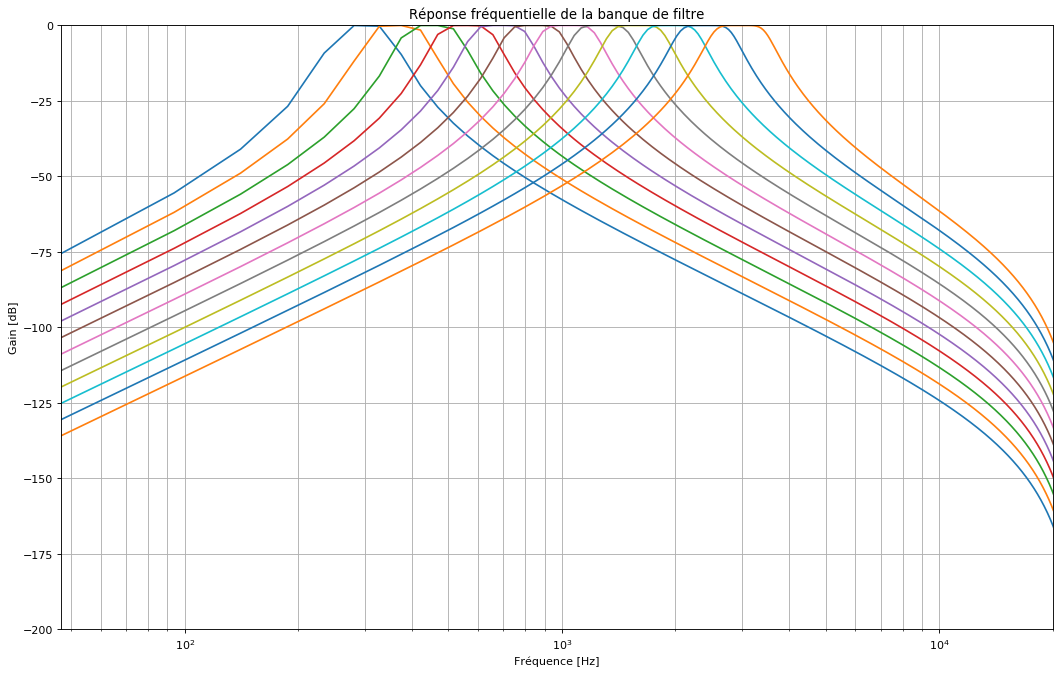

In [14]:
plot_freqz(filters)

### Application de la banque de filtres

Une étape intermédiaire qui consiste à appliquer les différents filtres sur le signal d'entrée.

Les signaux après filtrages sont générés par la fonction **gen_filtered(y, fs, filters)** et l'affichage des signaux filtrés est réalisé par **plot_filtered(y, t, filtered, filters_fq, nsub=4)**.

Le bleu marine représente le signal filtré et le bleu aquatique le signal d'origine.

In [15]:
#!masquer
# Génère les signaux après filtrage
# > y : Liste d'amplitudes
# > fs : Fréquence d'échantillonage
# > filters : Liste de filtres
# < filtered : Liste des signaux filtrés
def gen_filtered(y, fs, filters):
    # Initialisation
    filtered = []; N = len(y);
    t = np.linspace(0, N/fs, N)
    # Application des filtres
    for i in range(len(filters)):
        b, a = filters[i]
        filtered.append(lfilter(b, a, y))
    return filtered

In [16]:
#!masquer
# Affiche les signaux après filtrage
# > y : Signal original
# > t : Echelle temporelle
# > filtered : Liste des signaux filtrés
# > filters_fq : Listes d'objets contenant "fc", "fl" et "fh" indiquant les fréquences caractéristiques du filtre associé
# > [nsub] : Nombre de figures par ligne
def plot_filtered(y, t, filtered, filters_fq, nsub=4):
    # Initialisation
    nl = True; j = 0
    # Affichage
    for i in range(len(filtered)):
        # Figure
        if nl: 
            f, ax = plt.subplots(1, nsub, figsize=(16, 4), dpi= 80, facecolor="w", edgecolor="k")
            nl = False
        j = j +1
        # Affichage du spectre d'amplitude
        ax[i%nsub].set_title("Fc : {fc: >4}Hz ({fl: >4}Hz - {fh: >4}Hz)".format(fc=int(filters_fq[i]["fc"]), fl=int(filters_fq[i]["fl"]), fh=int(filters_fq[i]["fh"])))
        ax[i%nsub].set_xlabel("Time [s]")
        ax[i%nsub].set_ylabel("Amplitude [Ø]")
        ax[i%nsub].set_xlim(0, t[-1])
        ax[i%nsub].set_ylim(-1, +1)
        ax[i%nsub].plot(t, y/max(abs(y)), color="aqua")
        ax[i%nsub].plot(t, filtered[i]/max(abs(y)), color="darkblue")
        # Nouvelle figure si remplie
        if j%nsub == 0:
            nl = True
            plt.show()
    if j%nsub != 0: plt.show()

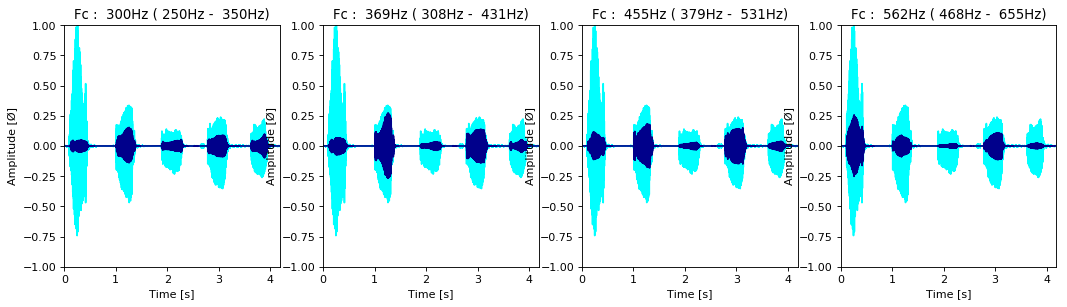

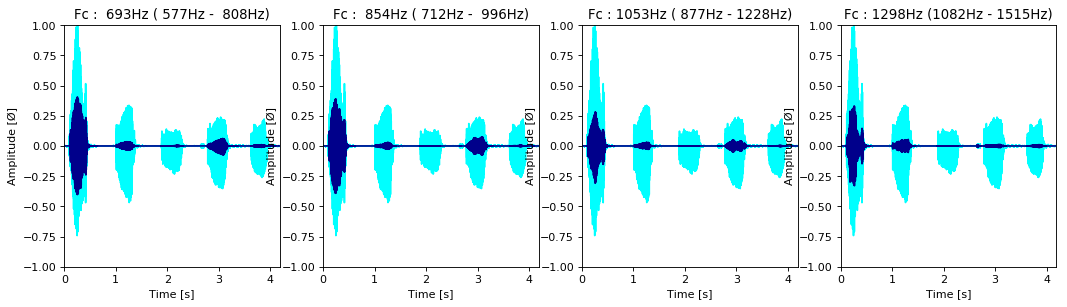

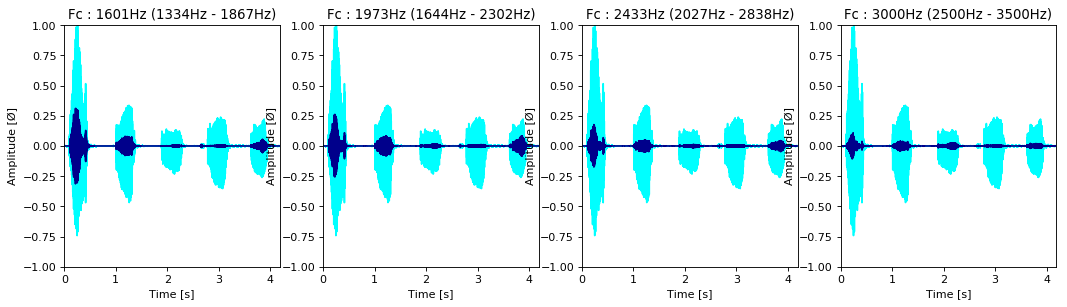

In [17]:
filtered = gen_filtered(y, fs, filters)
plot_filtered(y, t, filtered, filters_fq)

# Etude des signaux en sortie de la banque
Cette partie affiche le signal audio en sortie, le spectrogramme associé ainsi que les états après chaque application respective des filtres de la banque.

Les données du spectrogramme sont calculés par la fonction **gen_data(filtered, fs, time_res, amp_res, nm = 2)** puis affichées par la fonction **plot_data(ax, y, t, rspectrum, rfreqs, rtime, step)**.

In [18]:
#!masquer
# Affiche le spectrogramme
# > ax : Figure secondaire généré par la fonction gen_data
# > y : Signal d'entrée
# > t : Echelle temporelle
# > rspectrum : Spectre généré par la fonction gen_data
# > rfreqs : Liste de fréquences généré par la fonction gen_data
# > rtime : Liste de points temporels généré par la fonction gen_data
# > step : Pas de génération des filtres
def plot_data(ax, y, t, rspectrum, rfreqs, rtime):
    # Spectre d'amplitude
    ax[0].set_xlabel("Time [s]")
    ax[0].set_ylabel("Amplitude [Ø]")
    ax[0].plot(t, y/max(abs(y)), color="darkblue")
    ax[0].set_xlim(0, t[-1])
    ax[0].set_ylim(-1, +1)

    # Spectrogramme
    ax[1].cla()
    ax[1].set_ylabel("Frequency [Hz]")
    ax[1].set_xlabel("Time [s]")
    ax[1].set_yticks(np.geomspace(rfreqs[0], rfreqs[-1], len(rfreqs)))
    ax[1].pcolormesh(rtime, rfreqs, rspectrum)
    ax[1].set_xlim(0, t[-1])
    ax[1].plot()

    # Affichage
    plt.show()

In [19]:
#!masquer
# Calcul du spectrogramme
# > filtered : Liste de signaux filtrés
# > fs : Fréquence d'échantillonage
# > time_res : Résolution temporelle
# > amp_res : Résolution en amplitude
# > filters_fq : Listes d'objets contenant "fc", "fl" et "fh" indiquant les fréquences caractéristiques du filtre associé
# > [nm] : Permet de diviser le nombre de points à utiliser pour la FFT
# < ax : Figure secondaire
# < rspectrum : Spectre généré 
# < rfreqs : Liste de fréquences
# < rtime : Liste de points temporels
def gen_data(filtered, fs, time_res, amp_res, filters_fq, nm = 2):
    # Figure
    f, ax = plt.subplots(1, 2, figsize=(16, 5), dpi= 80, facecolor="w", edgecolor="k")
    rspectrum = [] ; rfreqs = [] ; rmax = []
    
    # NFFT 
        # Plus ce nombre est élevée, plus la résolution fréquentielle augemente
        # Cependant, le début et la fin seront "consommés" et aucune donnée ne pourra en être tirée
    NFFT = 2**int(math.log(fs, 2)-nm)

    # Traitement
    for i in range(len(filtered)):
        # Récupération du spectrogramme
        spectrum, freqs, rtime, img = ax[1].specgram(filtered[i], Fs=fs, NFFT=NFFT, noverlap=time_res*NFFT)
        
        # Regroupement de l'énergie par signal filtré 
            # La valeur étant au carré, il est nécessaire d'appliquer la racine avant addition
        summed = np.sqrt(spectrum[0])
        for k in range(1, len(freqs)): map(add, summed, np.sqrt(spectrum[k]))
        summed = np.power(summed, 2)
    
        # Numérisation
            # Le signal pourra être compris entre 0 et une valeur de saturation
            # Ensuite, cette valeur est quantifiée selon la résolution configurée, par arrondi
        vmax = 0.00000000001
        analog_data = np.clip(summed, 0, vmax)
        numeric_data = np.round(np.array(analog_data)/(vmax/(2**amp_res-1)))

        # Enregistrement
        rspectrum.append(numeric_data)
        rfreqs.append(filters_fq[i]["fc"])
        
    return ax, rspectrum, rfreqs, rtime

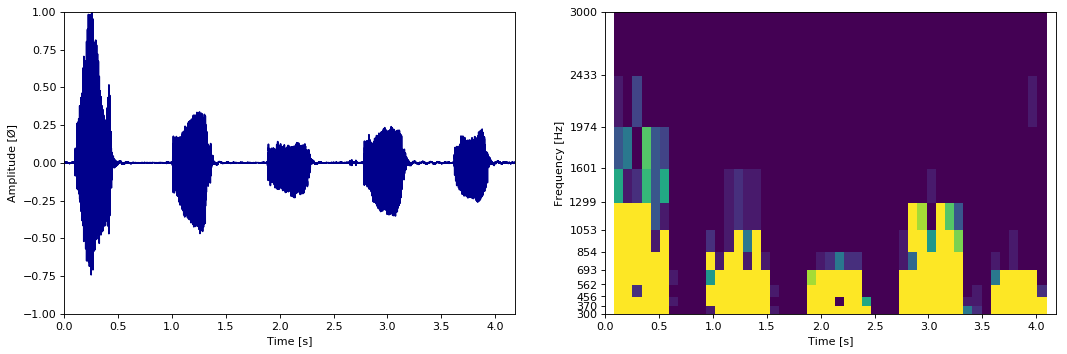

In [20]:
ax, rspectrum, rfreqs, rtime = gen_data(filtered, fs, time_res, amp_res, filters_fq)
plot_data(ax, y, t, rspectrum, rfreqs, rtime)

### Etude des états

Afin de faciliter le traitement des données, il est possible de lire la valeur d'un retournée par l'état d'un filtre à un instant *t* donnée en utilisant la fonction **state_at(filter_no, s, rspectrum, rtime)**.

In [21]:
#!masquer
# Récupère la valeur retournée par un filtre à un temps donnée
# > filter_no : Indice du filtre
# > s : Temps (valeur comprise entre 0 et la durée du signal audio)
# > rspectrum : Spectre généré par la fonction gen_data
# > rtime : Liste de points temporels généré par la fonction gen_data
# < states : Liste de valeurs numériques
def state_at(filter_no, s, rspectrum, rtime):
    # Calcul de l'indice dans la séquence
    i = 0
    while (i < len(rtime)) and (rtime[i] < s):
        i = i+1
    # Retourne l'état du filtre au temps spécifié
    return rspectrum[filter_no][i]

# Récapitulatif

Il est possible d'exécuter toutes les fonctions ci-dessus avec la fonction **compute(file, fs=0, time_res=0, amp_res=0, filters=False, fmin=0, fmax=0, nb_filters=0, q=0, n=0)**.

Afin de réduire les temps de calculs, il est possible d'exécuter cette fonction de différentes façons.

**Sélection de la source**
* **file** : Source du fichier à ouvrir (string)
OU 
* **file** : Signal d'entrée (liste d'amplitudes)
* **fs** : Fréquence d'échantillonage

**Sélection de la banque de filtres**
* **filters** : Banque de filtre déjà généré (permet d'éviter de les regénérer à chaque fois)
OU
* **fmin** : Fréquence minimum
* **fmax** : Fréquence maximum
* **nb_filters** : Nombre de filtres
* **q** : Facteur de qualité
* **n** : Ordre du filtre

**Configuration du spectrogramme**
* **time_res** : Résolution temporelle
* **amp_res** : Résolution en amplitude

In [22]:
#!masquer
# Exécute le code dans sa totalité.
# Cette fonction peut peut être utilisé de plusieurs façons avant d'optimiser les temps de calculs.
#
# Sélection de la source
#    > file : Source du fichier à ouvrir (string)
#    OU 
#    > file : Signal d'entrée (liste d'amplitudes)
#    > fs : Fréquence d'échantillonage
#
# Sélection de la banque de filtres
#    > filters : Banque de filtre déjà généré (permet d'éviter de les regénérer à chaque fois)
#    OU 
#    > fmin : Fréquence minimum
#    > fmax : Fréquence maximum
#    > nb_filters : Nombre de filtres
#    > q : Facteur de qualité
#    > n : Ordre du filtre
#
# Configuration du spectrogramme
#    > time_res : Résolution temporelle
#    > amp_res : Résolution en amplitude
#
def compute(file, fs=0, time_res=0, amp_res=0, fmin=0, fmax=0, nb_filters=0, q=0, n=0, filters=[]):
    # Récupération du fichier audio
    if type(file) == str:
        fs, y = sw.read(file)
    else:
        y = file
    N = len(y)
    t = np.linspace(0, N/fs, N)
    
    # Filtrage
    if nb_filters > 0:
        filters, filters_fq = gen_filters(fmin, fmax, nb_filters, q, n, fs)
    filtered = gen_filtered(y, fs, filters)
    
    # Traitement
    ax, rspectrum, rfreqs, rtime = gen_data(filtered, fs, time_res, amp_res, filters_fq)
    plot_data(ax, y, t, rspectrum, rfreqs, rtime)

Example d'utilisation :

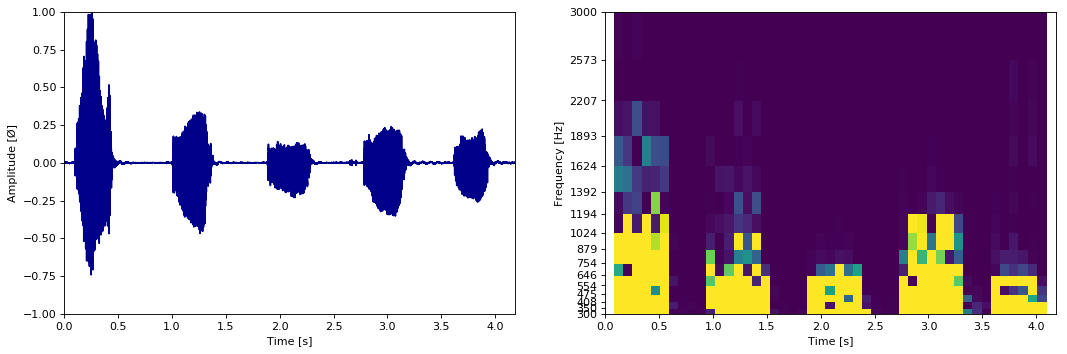

In [23]:
compute(
    file="src/test2.wav", 
    fmin=300, 
    fmax=3000, 
    nb_filters=16, 
    q=3, 
    n=3, 
    time_res=0.5, 
    amp_res=12
)

# Traitement à la volée

Si **[pyaudio](https://people.csail.mit.edu/hubert/pyaudio/)** est installé sur votre machine, il est possible d'enregistrer des sons depuis votre microphone et de les traiter au fur et à mesure (avec un léger décalage).

Pour cela, assurer vous de configurer correctement les deux variables suivantes, ce qui permettra d'inclure de nouvelles bibliothèques requises pour faire fonctionner la suite de ce programme.

Vous pouvez également configurer plus en détail les différents paramètres pour l'enregistrement, même s'il est conseillé de les laisser tel quel.

In [24]:
# Chemin vers les bibliothèques Python
lib_path = "C:\Program Files\Python36\Lib\site-packages"

# Chemin où stocker le fichier audio généré
src_out = "src/output.wav"

In [25]:
#!masquer
import sys
sys.path.append(lib_path)
import pyaudio
import wave

# Format d'enregistrement
dformat = pyaudio.paInt16
# Nombre de canaux (mono est conseillé)
channels = 1
# Fréquence d'échantillonage
fs = 48000
# Taille des blocs enregistrés
chunk_size = 1024

In [26]:
# Durée de l'enregistrement
duration = 5

Exécutez la prochaine cellule pour commencer un nouvel enregistrement.

* Enregistrement
* Terminé


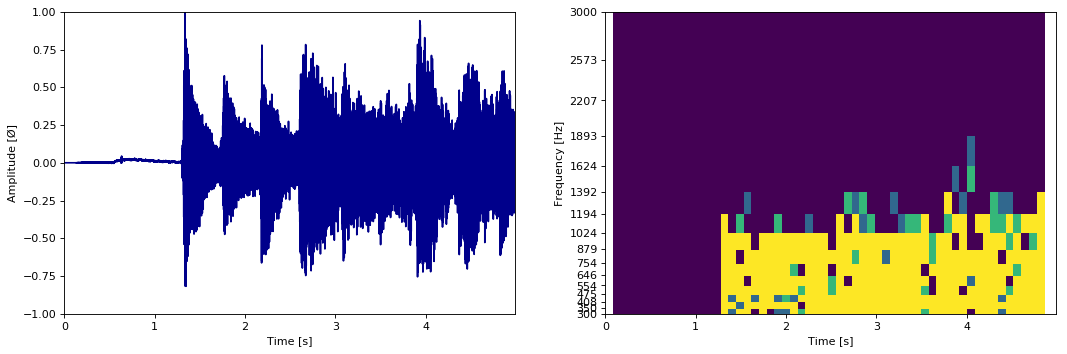

In [27]:
#!masquer
# Initialisation
p = pyaudio.PyAudio()

# Ouverture du flux
stream = p.open(format=dformat, channels=channels, rate=fs, input=True, frames_per_buffer=chunk_size)
frames = []
print("* Enregistrement")

# Enregistrement
for i in range(0, int(fs / chunk_size * duration)):
    data = stream.read(chunk_size)
    frames.append(data)

# Fermeture du flux
print("* Terminé")
stream.stop_stream()
stream.close()
p.terminate()

# Ecriture du fichier
wf = wave.open(src_out, "wb")
wf.setnchannels(channels)
wf.setsampwidth(p.get_sample_size(dformat))
wf.setframerate(fs)
wf.writeframes(b''.join(frames))
wf.close()

# Traitement
compute(
    file=src_out, 
    fmin=300, 
    fmax=3000, 
    nb_filters=16, 
    q=3, 
    n=3, 
    time_res=0.5, 
    amp_res=2
)